In [1]:
library(tidyverse)
library(mediation)
library(brms)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the ]8;;http://conflicted.r-lib.org/conflicted package]8;; to force all conflicts to become errors


Warning messages:
1: package ‘tidyverse’ was built under R version 4.3.3 
2: package ‘ggplot2’ was built under R version 4.3.3 
3: package ‘lubridate’ was built under R version 4.3.2 


Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: mvtnorm
Loading required package: sandwich
mediation: Causal Mediation Analysis
Version: 4.5.1



Warning messages:
1: package ‘mvtnorm’ was built under R version 4.3.3 
2: package ‘sandwich’ was built under R version 4.3.3 


Loading required package: Rcpp
Loading 'brms' package (version 2.22.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

Attaching package: ‘brms’

The following object is masked from ‘package:stats’:

    ar



Warning message:
package ‘brms’ was built under R version 4.3.3 


# Import Dataset

In [2]:
# -------------------------------
# 1. Define outcome measures (pre/post)
# -------------------------------
outcome_measures <- list(
  # Vascular
  fmd        = list(pre = "fmd_percent_pre", post = "fmd_percent_post"),
  # CPET
  vo2_rel    = list(pre = "cpet_vo2peak_relative_pre", post = "cpet_vo2peak_relative_post"),
  vo2_abs    = list(pre = "cpet_vo2peak_absolute_pre", post = "cpet_vo2peak_absolute_post"),
  vo2_perc   = list(pre = "cpet_vo2max_percentpredicted_pre", post = "cpet_vo2max_percentpredicted_post"),
  # Respiratory
  mip_pre    = list(pre = "mip_pre_max_pre", post = "mip_pre_max_post"),
  mip_post   = list(pre = "mip_post_max_pre", post = "mip_post_max_post"),
  smip_pre   = list(pre = "smip_pre_max_pre", post = "smip_pre_max_post"),
  smip_post  = list(pre = "smip_post_max_pre", post = "smip_post_max_post"),
  pif_pre    = list(pre = "pif_pre_max_pre", post = "pif_pre_max_post"),
  pif_post   = list(pre = "pif_post_max_pre", post = "pif_post_max_post"),
  sindex_pre = list(pre = "sindex_pre_max_pre", post = "sindex_pre_max_post"),
  sindex_post= list(pre = "sindex_post_max_pre", post = "sindex_post_max_post"),
  # Subjective
  fss        = list(pre = "fss_sum_pre", post = "fss_sum_post"),
  dsq        = list(pre = "dsq_sum_pre", post = "dsq_sum_post"),
  woods      = list(pre = "woods_sum_pre", post = "woods_sum_post"),
  vas_fatigue= list(pre = "vas_fatiguecurrent_pre", post = "vas_fatiguecurrent_post"),
  psqi       = list(pre = "psqi_sum_pre", post = "psqi_sum_post"),
  sfpa       = list(pre = "sfpa_sum_pre", post = "sfpa_sum_post")
)

In [3]:
library(tidyverse)
library(mediation)

# Import
df_long <- read.csv("C:/Users/ZCooper/Documents/GitHub/longcovid/df_RCT.csv")

# Programmatically extract all raw column names from outcome_measures
all_columns_raw <- unique(unlist(lapply(outcome_measures, function(x) c(x$pre, x$post))))
# But remove the _pre/_post suffix, since df_long doesn't have it yet
all_columns_raw <- gsub("_pre$", "", all_columns_raw)
all_columns_raw <- gsub("_post$", "", all_columns_raw)

# 3a. Pivot long → wide
df <- df_long %>%
  pivot_wider(
    id_cols = c(record_id, interventiongroup),
    names_from = time_point,
    values_from = all_of(all_columns_raw)
  )

# 3b. Rename columns (_1 → _pre, _2 → _post)
df <- df %>%
  rename_with(~ str_replace(.x, "_1$", "_pre")) %>%
  rename_with(~ str_replace(.x, "_2$", "_post"))


In [4]:
# 4. Compute change scores
# -------------------------------
for (var in names(outcome_measures)) {
  pre_col  <- outcome_measures[[var]]$pre
  post_col <- outcome_measures[[var]]$post
  change_col <- paste0(var, "_change")
  
  df[[change_col]] <- df[[post_col]] - df[[pre_col]]
}

print(colnames(df))

 [1] "record_id"                         "interventiongroup"                
 [3] "fmd_percent_pre"                   "fmd_percent_post"                 
 [5] "cpet_vo2peak_relative_pre"         "cpet_vo2peak_relative_post"       
 [7] "cpet_vo2peak_absolute_pre"         "cpet_vo2peak_absolute_post"       
 [9] "cpet_vo2max_percentpredicted_pre"  "cpet_vo2max_percentpredicted_post"
[11] "mip_pre_max_pre"                   "mip_pre_max_post"                 
[13] "mip_post_max_pre"                  "mip_post_max_post"                
[15] "smip_pre_max_pre"                  "smip_pre_max_post"                
[17] "smip_post_max_pre"                 "smip_post_max_post"               
[19] "pif_pre_max_pre"                   "pif_pre_max_post"                 
[21] "pif_post_max_pre"                  "pif_post_max_post"                
[23] "sindex_pre_max_pre"                "sindex_pre_max_post"              
[25] "sindex_post_max_pre"               "sindex_post_max_post"             

# Frequentist Mediation

## ANCOVA


Mediator model (summary):
# A tibble: 3 × 7
  term                   estimate std.error statistic p.value conf.low conf.high
  <chr>                     <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl>
1 (Intercept)               1.41      3.67      0.384 7.08e-1   -6.67       9.49
2 cpet_vo2peak_relative…    0.873     0.168     5.20  2.93e-4    0.504      1.24
3 interventiongroup         5.48      2.62      2.09  6.07e-2   -0.293     11.2 

Outcome model (summary):
# A tibble: 5 × 7
  term                   estimate std.error statistic p.value conf.low conf.high
  <chr>                     <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl>
1 (Intercept)               1.75     29.8      0.0588  0.954   -65.6       69.1 
2 fss_sum_pre               0.756     0.403    1.87    0.0936   -0.156      1.67
3 cpet_vo2peak_relative…    0.948     0.752    1.26    0.239    -0.753      2.65
4 cpet_vo2peak_relative…   -0.764     0.945   -0.808   0.440    -2.90       1.37
5 interventiongroup 

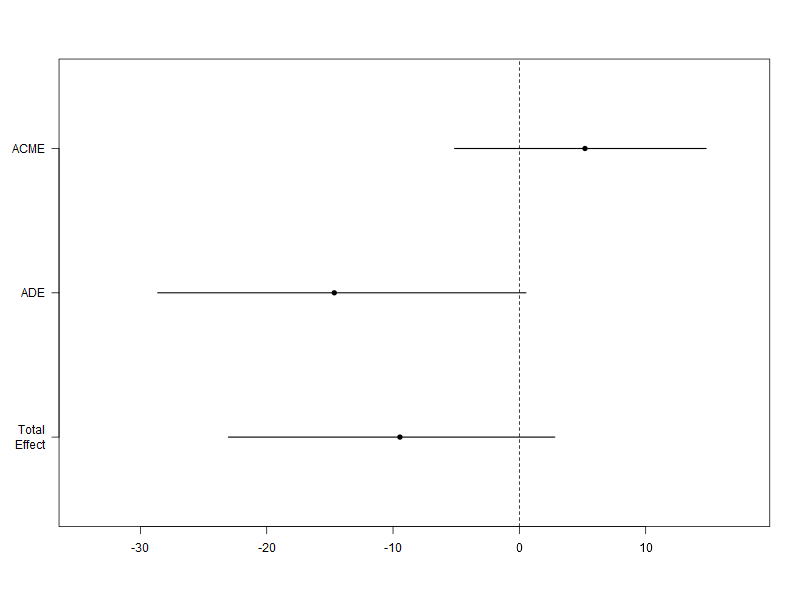

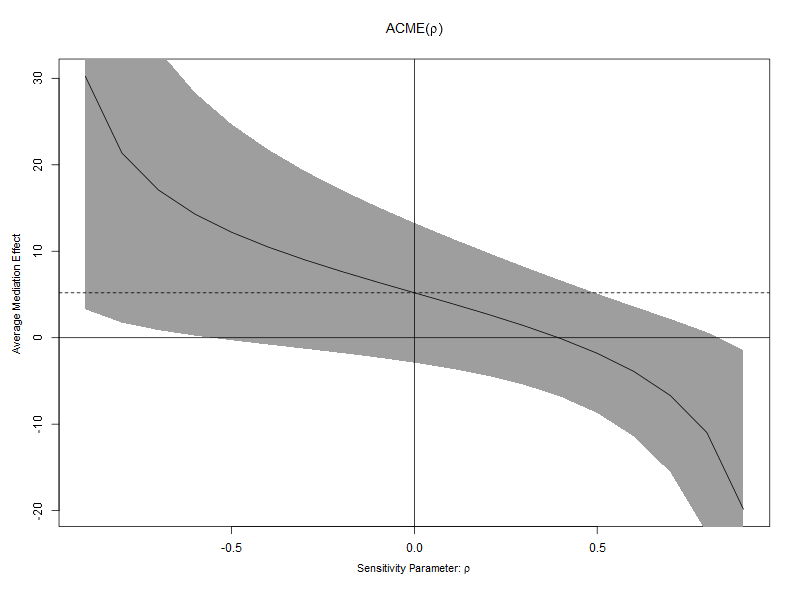

In [21]:
# Packages (install if needed)
# install.packages(c("mediation","broom"))
library(mediation)
library(broom)

# ---- 1. Quick checks & prepare data ----
# change these names if you want a different pair
mediator_post  <- "cpet_vo2peak_relative_post"
mediator_pre   <- "cpet_vo2peak_relative_pre"
outcome_post   <- "fss_sum_post"
outcome_pre    <- "fss_sum_pre"
treat_var      <- "interventiongroup"

# Ensure columns exist
missing_vars <- setdiff(c(mediator_post, mediator_pre, outcome_post, outcome_pre, treat_var), colnames(df))
if(length(missing_vars) > 0) stop("Missing variables in df: ", paste(missing_vars, collapse = ", "))

# Ensure treatment is numeric 0/1
if(!is.numeric(df[[treat_var]])) {
  # try to coerce factors to 0/1
  if(is.factor(df[[treat_var]])) {
    levs <- levels(df[[treat_var]])
    message("Coercing factor treatment to numeric 0/1 using first two levels: ", paste(levs[1:min(2,length(levs))], collapse = ", "))
    df[[treat_var]] <- as.numeric(df[[treat_var]]) - 1
  } else {
    df[[treat_var]] <- as.numeric(df[[treat_var]])
  }
}

# ---- 2. Fit the component models (ANCOVA-style) ----
# Mediator model: mediator_post ~ mediator_pre + treatment
med_formula <- as.formula(paste0(mediator_post, " ~ ", mediator_pre, " + ", treat_var))
model.M <- lm(med_formula, data = df)

# Outcome model: outcome_post ~ outcome_pre + mediator_post + mediator_pre + treatment
out_formula <- as.formula(paste0(outcome_post, " ~ ", outcome_pre, " + ", mediator_post, " + ", mediator_pre, " + ", treat_var))
model.Y <- lm(out_formula, data = df)

# Quick model checks
cat("\nMediator model (summary):\n"); print(broom::tidy(model.M, conf.int = TRUE))
cat("\nOutcome model (summary):\n");  print(broom::tidy(model.Y, conf.int = TRUE))

# ---- 3. Run mediation (Imai et al.) ----
set.seed(123)  # reproducible bootstrap
med_out <- mediate(model.M, model.Y,
                   treat = treat_var,
                   mediator = mediator_post,
                   boot = TRUE,
                   sims = 5000)   # increase sims if you want more precision

# ---- 4. Print results ----
summary(med_out)

# Useful pieces:
# med_out$d0        -> ACME (average causal mediation effect)
# med_out$tau.coef  -> total effect
# med_out$z0        -> ADE (direct effect, sometimes labeled differently)
# med_out$n0        -> proportion mediated (when defined)

# ---- 5. Plot mediation results ----
# simple plot of ACME/ADE CIs
plot(med_out)           # forest-like plots (ACME, ADE, total)

# ---- 6. Sensitivity analysis (how strong unobserved confounding must be) ----
sens <- medsens(med_out, rho.by = 0.1, sims = 1000)
print(sens)
plot(sens)


In [11]:
# View
View(tidy_results)

In [46]:
# 6. Run frequentist mediation loop
# -------------------------------
mediation_results <- data.frame(
  mediator = character(),
  outcome = character(),
  ACME = numeric(),
  ACME_p = numeric(),
  ADE = numeric(),
  ADE_p = numeric(),
  total_effect = numeric(),
  prop_mediated = numeric(),
  stringsAsFactors = FALSE
)

for (med in objective_changes) {
  for (out in all_changes) {
    
    if (med == out) next
    
    # Fit mediator model
    med_model <- lm(as.formula(paste0(med, " ~ interventiongroup")), data = df)
    
    # Fit outcome model
    out_model <- lm(as.formula(paste0(out, " ~ ", med, " + interventiongroup")), data = df)
    
    # Run mediation with bootstrapping
    med_fit <- mediate(med_model, out_model,
                       treat = "interventiongroup",
                       mediator = med,
                       boot = TRUE, sims = 5000)
    
    # Extract results
    res <- data.frame(
      mediator = med,
      outcome = out,
      ACME = med_fit$d0,
      ACME_p = med_fit$d0.p,
      ADE = med_fit$z0,
      ADE_p = med_fit$z0.p,
      total_effect = med_fit$tau.coef,
      prop_mediated = med_fit$n0
    )
    
    mediation_results <- bind_rows(mediation_results, res)
  }
}

Running nonparametric bootstrap

Running nonparametric bootstrap

Running nonparametric bootstrap



Warning messages:
1: In predict.lm(new.fit.M, type = "response", newdata = pred.data.t) :
  prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases
2: In predict.lm(new.fit.Y, type = "response", newdata = pred.data.t) :
  prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases
3: In predict.lm(new.fit.Y, type = "response", newdata = pred.data.c) :
  prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases
4: In predict.lm(new.fit.Y, type = "response", newdata = pred.data.t) :
  prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases
5: In predict.lm(new.fit.Y, type = "response", newdata = pred.data.t) :
  prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases


: Error in `mediate()`:
! number of observations do not match between mediator and outcome models

# Bayesian Mediation

In [5]:
library(brms)
library(dplyr)

# Define your lists of mediators and outcomes (change scores)
mediators <- c(
  "mip_pre_max_change", "mip_post_max_change",
  "smip_pre_max_change", "smip_post_max_change",
  "pif_pre_max_change", "pif_post_max_change",
  "sindex_pre_max_change", "sindex_post_max_change",
  "fmd_percent_change", "cpet_vo2peak_relative_change",
  "cpet_vo2peak_absolute_change", "cpet_vo2max_percentpredicted_change"
)

outcomes <- c(
  "fss_sum_change", "dsq_sum_change", "woods_sum_change",
  "vas_fatiguecurrent_change", "psqi_sum_change", "sfpa_sum_change"
)

# Prepare an empty list to store results
mediation_results <- list()

# Loop over mediators and outcomes
for (med in mediators) {
  for (out in outcomes) {
    cat("Running Bayesian mediation for mediator:", med, "→ outcome:", out, "\n")
    
    # Fit mediator model
    fit_M <- brm(
      formula = as.formula(paste(med, "~ interventiongroup")),
      data = df,
      family = gaussian(),
      prior = c(
        prior(normal(0, 10), class = "Intercept"),
        prior(normal(0, 1), class = "b"),
        prior(student_t(3, 0, 1), class = "sigma")
      ),
      chains = 4, iter = 4000, cores = 4, refresh = 0
    )
    
    # Fit outcome model
    fit_Y <- brm(
      formula = as.formula(paste(out, "~ interventiongroup +", med)),
      data = df,
      family = gaussian(),
      prior = c(
        prior(normal(0, 10), class = "Intercept"),
        prior(normal(0, 1), class = "b"),
        prior(student_t(3, 0, 1), class = "sigma")
      ),
      chains = 4, iter = 4000, cores = 4, refresh = 0
    )
    
    # Extract posterior samples
    post_M <- as_draws_df(fit_M) %>% dplyr::select(starts_with("b_")) %>% rename(beta_M = 1)
    post_Y <- as_draws_df(fit_Y) %>% dplyr::select(starts_with("b_")) %>% rename(gamma = paste0("b_", med), beta_Y = "b_interventiongroup")
    
    post <- cbind(post_M, post_Y)
    
    # Calculate ACME, ADE, Total
    post <- post %>%
      mutate(
        ACME = beta_M * gamma,
        ADE  = beta_Y,
        Total = ACME + ADE
      )
    
    # Summarize posterior
    summary <- post %>%
      summarise(
        mediator = med,
        outcome = out,
        ACME_mean = mean(ACME),
        ACME_lower = quantile(ACME, 0.025),
        ACME_upper = quantile(ACME, 0.975),
        ADE_mean = mean(ADE),
        ADE_lower = quantile(ADE, 0.025),
        ADE_upper = quantile(ADE, 0.975),
        Total_mean = mean(Total),
        Total_lower = quantile(Total, 0.025),
        Total_upper = quantile(Total, 0.975)
      )
    
    mediation_results[[paste(med, out, sep = "_")]] <- summary
  }
}

# Combine all results into one dataframe
mediation_summary_df <- bind_rows(mediation_results)
mediation_summary_df


Running Bayesian mediation for mediator: mip_pre_max_change → outcome: fss_sum_change 


: Error:
! The following variables can neither be found in 'data' nor in 'data2':
'mip_pre_max_change'

In [5]:
mediators <- c("mip_pre_change", "mip_post_change", "smip_pre_change", "smip_post_change")
outcomes  <- c("fss_change", "dsq_change", "woods_change", "vas_fatigue_change", "psqi_change", "sfpa_change")

for (med in mediators) {
  for (out in outcomes) {
    formula_str <- paste0(out, " ~ ", med, " + interventiongroup")
    fit <- brm(as.formula(formula_str), data = df, chains = 4, iter = 2000)
    print(fit)
  }
}


Compiling Stan program...
Start sampling

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.076 seconds (Warm-up)
Chain 1:                0.043 second

There were 24 warnings (use warnings() to see them)


## 8/16

In [ ]:
library(tidyverse)
library(brms)

# -------------------------------
# 1. Define outcome and mediator measures
# -------------------------------

# Subjective outcomes
outcome_measures <- list(
  fss        = list(pre = "fss_sum_pre", post = "fss_sum_post"),
  dsq        = list(pre = "dsq_sum_pre", post = "dsq_sum_post"),
  woods      = list(pre = "woods_sum_pre", post = "woods_sum_post"),
  vas_fatigue = list(pre = "vas_fatiguecurrent_pre", post = "vas_fatiguecurrent_post"),
  psqi       = list(pre = "psqi_sum_pre", post = "psqi_sum_post"),
  sfpa       = list(pre = "sfpa_sum_pre", post = "sfpa_sum_post")
)

# Objective mediators
mediator_measures <- list(
  mip_pre   = list(pre = "mip_pre_max_pre", post = "mip_pre_max_post"),
  mip_post  = list(pre = "mip_post_max_pre", post = "mip_post_max_post"),
  smip_pre  = list(pre = "smip_pre_max_pre", post = "smip_pre_max_post"),
  fmd       = list(pre = "fmd_percent_pre", post = "fmd_percent_post"),
  vo2_rel   = list(pre = "cpet_vo2peak_relative_pre", post = "cpet_vo2peak_relative_post")
)

# -------------------------------
# 2. Set priors (weakly informative for now)
# -------------------------------
priors <- c(
  prior(normal(0, 1), class = "b"),         
  prior(student_t(3, 0, 10), class = "sigma")
)

options(mc.cores = parallel::detectCores())  # parallelize chains

# -------------------------------
# 3. Loop through outcomes & mediators
# -------------------------------
results <- list()

for(outcome_name in names(outcome_measures)){
  outcome_post <- outcome_measures[[outcome_name]]$post
  outcome_pre  <- outcome_measures[[outcome_name]]$pre
  
  for(mediator_name in names(mediator_measures)){
    mediator_post <- mediator_measures[[mediator_name]]$post
    mediator_pre  <- mediator_measures[[mediator_name]]$pre
    
    # ANCOVA-style formula: post ~ mediator_post + mediator_pre + intervention
    formula_str <- paste0(outcome_post, " ~ ", mediator_post, " + ", mediator_pre, " + interventiongroup")
    
    fit <- brm(
      formula = as.formula(formula_str),
      data = df,
      prior = priors,
      chains = 4,
      iter = 2000,
      warmup = 1000,
      seed = 123,
      refresh = 0  # suppress verbose Stan output
    )
    
    # Save concise posterior summary
    results[[paste0(outcome_name, "_by_", mediator_name)]] <- posterior_summary(fit)
    
    cat("Finished model:", outcome_name, "by", mediator_name, "\n")
  }
}

# -------------------------------
# 4. Examine results
# -------------------------------
# Example: view FSS ~ MIP pre
results$fss_by_mip_pre



Compiling Stan program...
Start sampling
Finished model: fss by mip_pre 
Compiling Stan program...
Start sampling
Finished model: fss by mip_post 
Compiling Stan program...
Start sampling
Finished model: fss by smip_pre 
Compiling Stan program...
Start sampling
Finished model: fss by fmd 
Compiling Stan program...
Start sampling
Finished model: fss by vo2_rel 
Compiling Stan program...
Start sampling
Finished model: dsq by mip_pre 
Compiling Stan program...
Start sampling
Finished model: dsq by mip_post 
Compiling Stan program...
Start sampling
Finished model: dsq by smip_pre 
Compiling Stan program...
Start sampling
Finished model: dsq by fmd 
Compiling Stan program...
Start sampling
Finished model: dsq by vo2_rel 
Compiling Stan program...
Start sampling
Finished model: woods by mip_pre 
Compiling Stan program...
Start sampling
Finished model: woods by mip_post 
Compiling Stan program...
Start sampling
Finished model: woods by smip_pre 
Compiling Stan program...
Start sampling
Finish

There were 30 warnings (use warnings() to see them)


In [8]:
# Optional: combine all into a table for export
write.csv(do.call(rbind, results), "bayes_ancova_mediation_results.csv")


# End